### packages version

pandas==1.3.4
geopandas==0.6.1
pmdarima==1.8.5
libpysal==4.5.1
esda==2.4.1

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from convertbng.util import convert_bng, convert_lonlat
import geopandas as gpd
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
from shapely.geometry import Point, Polygon
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error

In [2]:
# code adaption: https://stackoverflow.com/questions/40428931/package-for-listing-version-of-packages-used-in-a-jupyter-notebook
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

pandas==1.3.4
geopandas==0.6.1
pmdarima==1.8.5


## Data input

In [3]:
# transform dataframe into a time series dataframe
def time_series_transform(SPdataframe):
    SPdataframe = SPdataframe.sort_values(by="date")
    SPdataframe = SPdataframe.reset_index()
    SPdataframe = SPdataframe.drop(columns=['index'])
    SPdataframe = SPdataframe.set_index('date')
    return SPdataframe

In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/NijunJiang/CEGE0042_data/main/F2018-2022.CSV')
London_borough_shp = gpd.read_file('/vsicurl/https://raw.githubusercontent.com/NijunJiang/CEGE0042_data/main/London_Borough_Excluding_MHW.shp')

In [5]:
data_spaceTime = data[["IncidentNumber",'PropertyCategory','DateOfCall','CalYear','TimeOfCall','Easting_rounded','Northing_rounded','IncGeo_BoroughName','IncGeo_BoroughCode']]

In [6]:
Easting_list = data_spaceTime['Easting_rounded'].tolist()
Northing_list = data_spaceTime['Northing_rounded'].tolist()

In [7]:
res_list = convert_lonlat(Easting_list, Northing_list)

In [8]:
lat_list = res_list[1]
lon_list = res_list[0]

In [9]:
%%capture
data_spaceTime['latitude'] = lat_list
data_spaceTime['longitude'] = lon_list

In [10]:
%%capture
data_spaceTime
data_spaceTime["DateOfCall"]= pd.to_datetime(data_spaceTime["DateOfCall"])
data_spaceTime['Year_M'] = pd.to_datetime(data_spaceTime["DateOfCall"]).dt.to_period('M')

In [11]:
%%capture
data_spaceTime.rename(
    columns={"IncGeo_BoroughCode": "GSS_CODE"}, inplace=True
)

In [12]:
data_spaceTime = data_spaceTime.loc[data_spaceTime['PropertyCategory'] == 'Dwelling']

## Exploratory data analysis

No handles with labels found to put in legend.


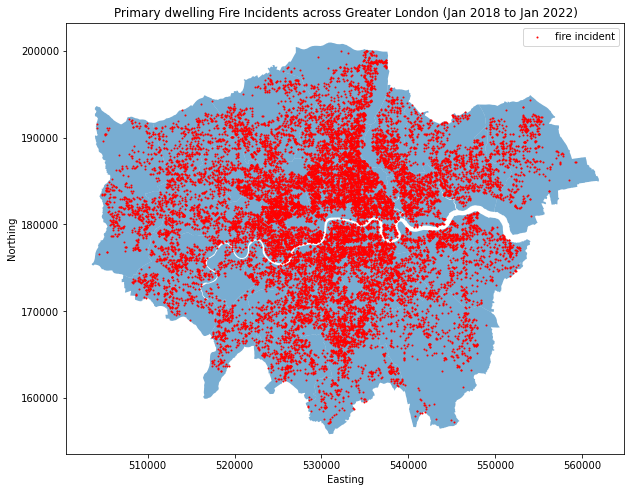

In [13]:
# code adaption:https://github.com/NijunJiang/CASA0006_2022/blob/main/coursework.ipynb
crs = {"init": "epsg:27700"}  # coordinate reference system for the easting and northing

geometry = [Point(xy) for xy in zip(data_spaceTime["Easting_rounded"], data_spaceTime["Northing_rounded"])]

geodata = gpd.GeoDataFrame(data_spaceTime, crs=crs, geometry=geometry)  # fire incident point data

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
ax.set_title("Primary dwelling Fire Incidents across Greater London (Jan 2018 to Jan 2022)")

London_borough_shp.plot(ax=ax, legend=True,  categorical=True, alpha=0.6)
ax.legend()
ax.scatter(
    data_spaceTime["Easting_rounded"],
    data_spaceTime["Northing_rounded"],
    label="fire incident",
    s=1,
    c="red",
)
ax.legend()


In [14]:
#pivot tables
data_spaceTime_dayCount = data_spaceTime["DateOfCall"].value_counts()

data_spaceTime_MonthCount = data_spaceTime["Year_M"].value_counts()

data_spaceTime_boroughCount = data_spaceTime["GSS_CODE"].value_counts()

data_spaceTime_Ealing = data_spaceTime.loc[data_spaceTime['GSS_CODE'] == 'E09000009']

In [15]:
GSS_list = list(data_spaceTime.GSS_CODE.unique())

In [16]:
# pivot tables to time series dataframes
data_spaceTime_dayCount_frame = pd.DataFrame(
    {
        "date": data_spaceTime_dayCount.index,
        "count": data_spaceTime_dayCount.values,
    }
)

data_spaceTime_MonthCount_frame = pd.DataFrame(
    {
        "date": data_spaceTime_MonthCount.index,
        "count": data_spaceTime_MonthCount.values,
    }
)

data_spaceTime_boroughCount_frame = pd.DataFrame(
    {
        "GSS_CODE": data_spaceTime_boroughCount.index,
        "count": data_spaceTime_boroughCount.values,
    }
)

In [17]:
# merge incident counts into geo dataframe
London_borough_shp_wCount = pd.merge(
    London_borough_shp, data_spaceTime_boroughCount_frame, on="GSS_CODE"
) 



In [18]:
#calculate incidents per unit area
London_borough_shp_wCount["incidents per hectares"] =London_borough_shp_wCount[
    "count"
] / (
    London_borough_shp_wCount["HECTARES"]
) 

[None, None]

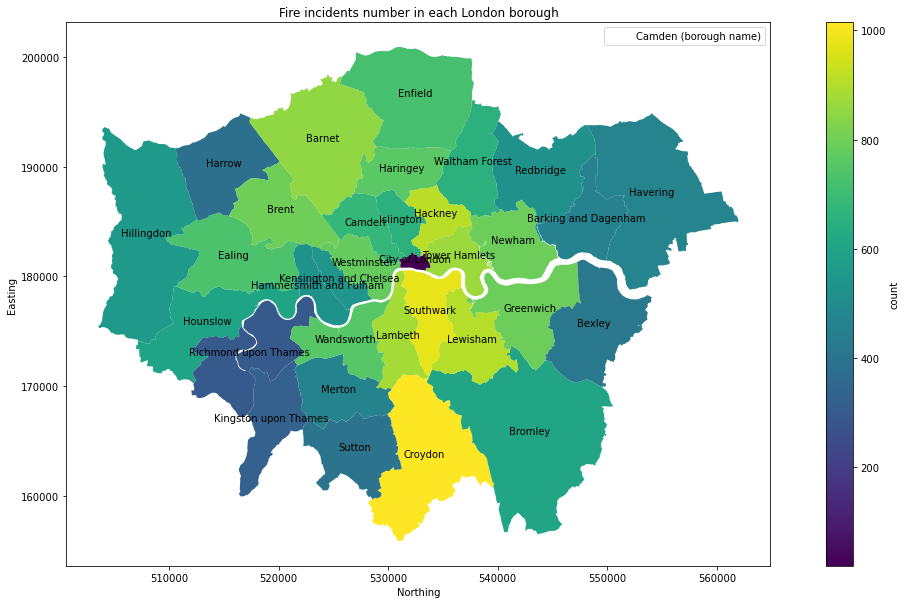

In [19]:
#code adapted from https://github.com/NijunJiang/CASA0006_2022/blob/main/coursework.ipynb
fig, ax = plt.subplots(figsize=(20, 10))
London_borough_shp_wCount.plot(
    column="count",
    ax=ax,
    legend=True,
    legend_kwds={"label": "count"},
)
London_borough_shp_wCount.apply(  # add community number to the polygon
    lambda x: ax.annotate(
        text=x["NAME"],
        xy=x.geometry.centroid.coords[0],
        ha="center",
        color="black",
    ),
    axis=1,
)

ax.set_xlabel("Northing")
ax.set_ylabel("Easting")
ax.set_title("Fire incidents number in each London borough")

plt.plot([], [], " ", label="Camden (borough name)")
legend = plt.legend()
plt.setp(legend.get_texts(), color="black")


[None, None]

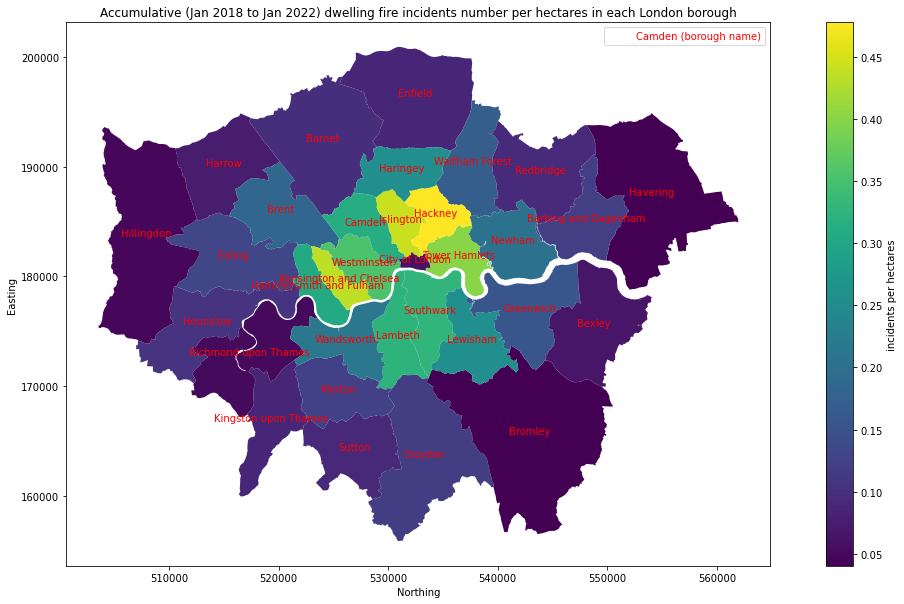

In [20]:
#code adapted from https://github.com/NijunJiang/CASA0006_2022/blob/main/coursework.ipynb
fig, ax = plt.subplots(figsize=(20, 10))
London_borough_shp_wCount.plot(
    column="incidents per hectares",
    ax=ax,
    legend=True,
    legend_kwds={"label": "incidents per hectares"},
)
London_borough_shp_wCount.apply(  # add borough name
    lambda x: ax.annotate(
        text=x["NAME"],
        xy=x.geometry.centroid.coords[0],
        ha="center",
        color="red",
    ),
    axis=1,
)

ax.set_xlabel("Northing")
ax.set_ylabel("Easting")
ax.set_title("Accumulative (Jan 2018 to Jan 2022) dwelling fire incidents number per hectares in each London borough")

plt.plot([], [], " ", label="Camden (borough name)")
legend = plt.legend()
plt.setp(legend.get_texts(), color="red")


In [21]:
data_spaceTime.to_csv (r'D:\Master\export_dataframe.csv', index = False, header=True)

In [22]:
data_spaceTime_MonthCount_frame = time_series_transform(SPdataframe=data_spaceTime_MonthCount_frame)
data_spaceTime_dayCount_frame = time_series_transform(SPdataframe=data_spaceTime_dayCount_frame)

<AxesSubplot:title={'center':'Monthly London dwelling fire incident trend'}, xlabel='date', ylabel='incidents number'>

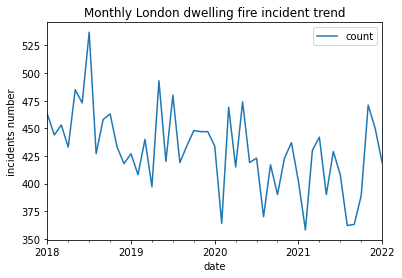

In [23]:
data_spaceTime_MonthCount_frame.plot(ylabel='incidents number',title='Monthly London dwelling fire incident trend')

## Results

In [24]:
data_spaceTime_MonthCount_frame.index = data_spaceTime_MonthCount_frame.index.to_timestamp()

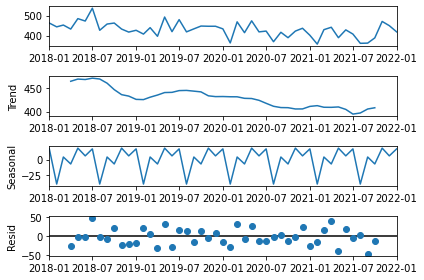

In [25]:
# time series decomposition
result = seasonal_decompose(data_spaceTime_MonthCount_frame, model='additive',period=6)
result.plot();

In [26]:
#differencing
data_spaceTime_MonthCount_frame_diff = data_spaceTime_MonthCount_frame.diff()

### Stationary check

In [27]:
# Augmented Dickey Fuller Test
df_stationarityTest = adfuller(data_spaceTime_MonthCount_frame_diff['count'][1:], autolag='AIC')
print("p-value: ", df_stationarityTest[1])

p-value:  0.000862416446662742


In [28]:
# Augmented Dickey Fuller Test
df_stationarityTest = adfuller(data_spaceTime_MonthCount_frame['count'], autolag='AIC')
print("p-value: ", df_stationarityTest[1])

p-value:  0.6103458702195137


In [29]:
data_spaceTime_MonthCount_frame_diff = data_spaceTime_MonthCount_frame_diff.iloc[1:]

### ARIMA

D:\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


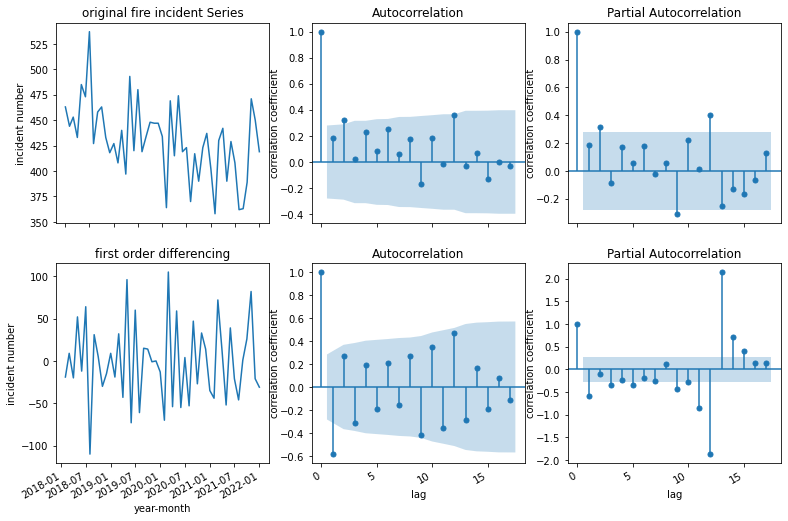

In [30]:
plt.rcParams.update({'figure.figsize':(13,9)})


# code adaption: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
# original time series
fig, axes = plt.subplots(2, 3)

axes[0, 0].plot(data_spaceTime_MonthCount_frame); axes[0, 0].set_title('original fire incident Series');
axes[0, 0].set_ylabel('incident number') 
plot_acf(data_spaceTime_MonthCount_frame, ax=axes[0, 1]);
axes[0, 1].set_ylabel('correlation coefficient',labelpad=0.1) 
plot_pacf(data_spaceTime_MonthCount_frame, ax=axes[0, 2]);
axes[0, 2].set_ylabel('correlation coefficient',labelpad=0.1) 
fig.autofmt_xdate()


# first order differencing
axes[1, 0].plot(data_spaceTime_MonthCount_frame.diff()); axes[1, 0].set_title('first order differencing')
axes[1, 0].set_ylabel('incident number') 
axes[1, 0].set_xlabel('year-month') 
plot_acf(data_spaceTime_MonthCount_frame.diff().dropna(), ax=axes[1, 1]);
axes[1, 1].set_ylabel('correlation coefficient',labelpad=0.1) 
axes[1, 1].set_xlabel('lag') 
plot_pacf(data_spaceTime_MonthCount_frame.diff().dropna(), ax=axes[1, 2]);
axes[1, 2].set_ylabel('correlation coefficient',labelpad=0.1) 
axes[1, 2].set_xlabel('lag') 
fig.autofmt_xdate()

In [31]:
training = data_spaceTime_MonthCount_frame[:40]
testing = data_spaceTime_MonthCount_frame[40:]

In [32]:
model = ARIMA(training, order=(1, 1, 1),seasonal_order=(2,0,1,12))  
model_fit = model.fit()  

D:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


In [33]:
prediction = model_fit.forecast(steps=9) # nine months prediction

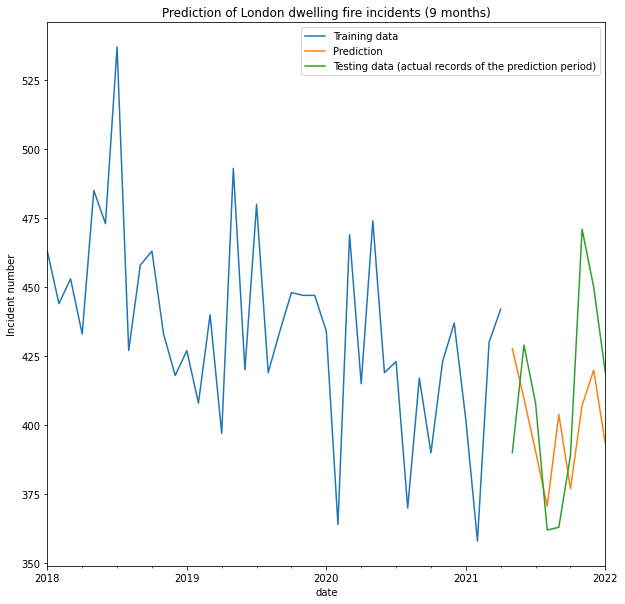

In [34]:
fig, ax = plt.subplots(figsize=(10, 10))
training.plot(ax=ax)
prediction.plot(ax=ax)
testing.plot(ax=ax)
ax.set_ylabel('Incident number')
ax.set_title('Prediction of London dwelling fire incidents (9 months)')
ax.legend(['Training data', 'Prediction','Testing data (actual records of the prediction period)'])

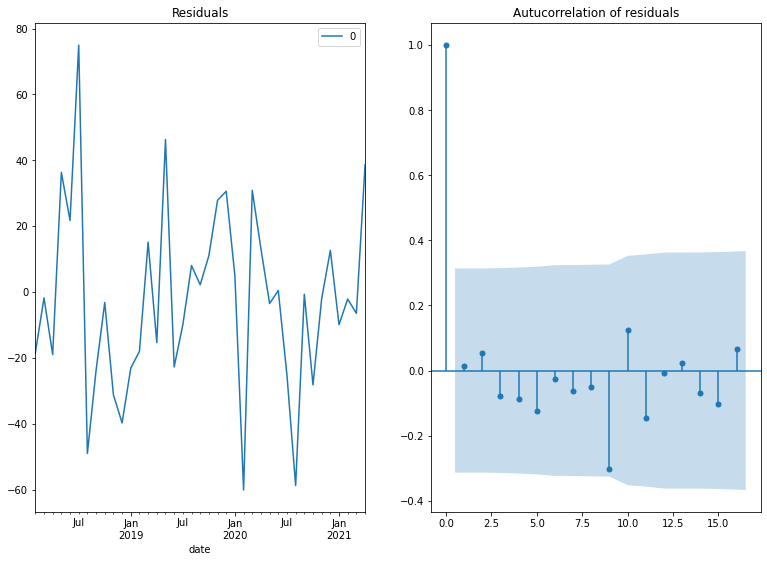

In [35]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals[1:].plot(title="Residuals", ax=ax[0])
plot_acf(residuals[1:], ax=ax[1],title="Autucorrelation of residuals");
plt.show()

In [36]:
rms = mean_squared_error(testing, prediction, squared=False)
print('root-mean-squared error is ' +str(rms)) 

root-mean-squared error is 32.73054998191163


In [37]:
mean_absolute_error(testing, prediction)

28.41840552011509

In [38]:
mean_absolute_percentage_error(testing, prediction)

0.06843135501448977

# spatial auto-correlation

In [39]:
import libpysal
import esda
# code adaption: https://geographicdata.science/book/notebooks/07_local_autocorrelation.html
weights = libpysal.weights.Queen.from_dataframe(London_borough_shp_wCount) 
spatial_auto = esda.Moran(London_borough_shp_wCount[['incidents per hectares']], weights)

In [40]:
spatial_auto.I

0.28690346910576153

In [41]:
spatial_auto.p_sim

0.009

# Ealing

In [42]:
data_spaceTime_MonthCount_Ealing = data_spaceTime_Ealing["Year_M"].value_counts()

In [43]:
data_spaceTime_MonthCount_Ealing_frame = pd.DataFrame(
    {
        "date": data_spaceTime_MonthCount_Ealing.index,
        "count": data_spaceTime_MonthCount_Ealing.values,
    }
)

In [44]:
data_spaceTime_MonthCount_Ealing_frame = time_series_transform(SPdataframe=data_spaceTime_MonthCount_Ealing_frame)

In [45]:
data_spaceTime_MonthCount_Ealing_frame.index = data_spaceTime_MonthCount_Ealing_frame.index.to_timestamp()

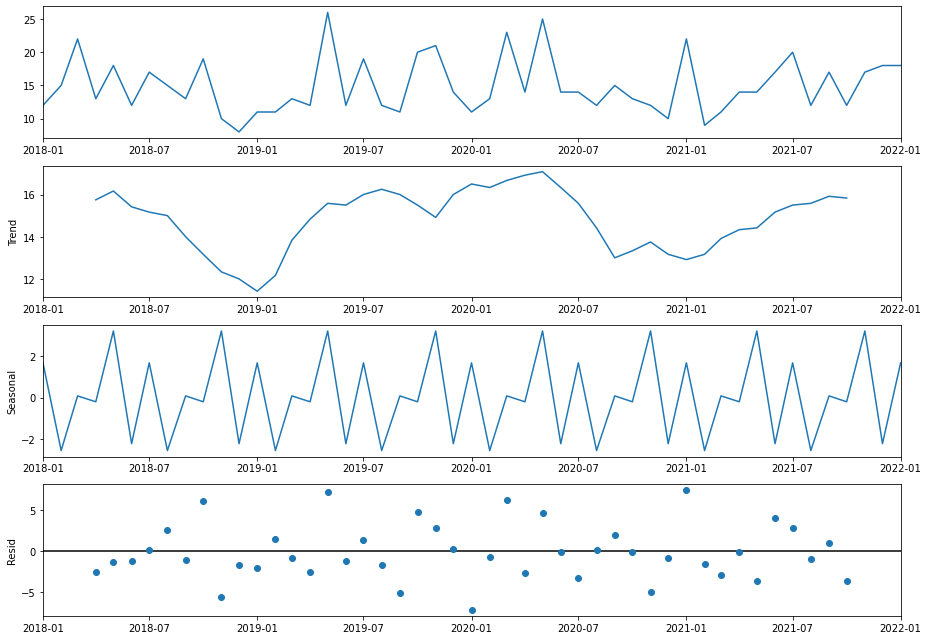

In [46]:
result = seasonal_decompose(data_spaceTime_MonthCount_Ealing_frame, model='additive',period=6)
result.plot();

In [47]:
df_stationarityTest = adfuller(data_spaceTime_MonthCount_Ealing_frame, autolag='AIC')
print("P-value: ", df_stationarityTest[1])

P-value:  1.3093071858131246e-11


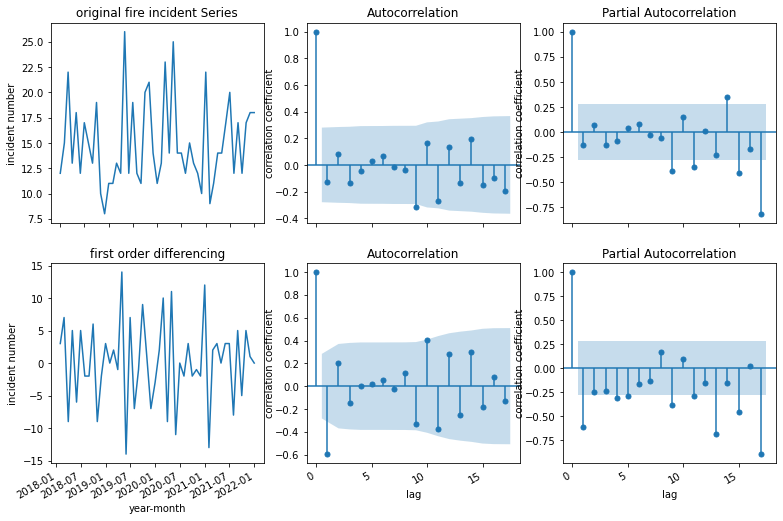

In [48]:
plt.rcParams.update({'figure.figsize':(13,9)})


#code adaption: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
# original time series
fig, axes = plt.subplots(2, 3)

axes[0, 0].plot(data_spaceTime_MonthCount_Ealing_frame); axes[0, 0].set_title('original fire incident Series');
axes[0, 0].set_ylabel('incident number') 
plot_acf(data_spaceTime_MonthCount_Ealing_frame, ax=axes[0, 1]);
axes[0, 1].set_ylabel('correlation coefficient',labelpad=0.1) 
plot_pacf(data_spaceTime_MonthCount_Ealing_frame, ax=axes[0, 2]);
axes[0, 2].set_ylabel('correlation coefficient',labelpad=0.1) 
fig.autofmt_xdate()

# first order differencing
axes[1, 0].plot(data_spaceTime_MonthCount_Ealing_frame.diff()); axes[1, 0].set_title('first order differencing')
axes[1, 0].set_ylabel('incident number') 
axes[1, 0].set_xlabel('year-month') 
plot_acf(data_spaceTime_MonthCount_Ealing_frame.diff().dropna(), ax=axes[1, 1]);
axes[1, 1].set_ylabel('correlation coefficient',labelpad=0.1) 
axes[1, 1].set_xlabel('lag') 
plot_pacf(data_spaceTime_MonthCount_Ealing_frame.diff().dropna(), ax=axes[1, 2]);
axes[1, 2].set_ylabel('correlation coefficient',labelpad=0.1) 
axes[1, 2].set_xlabel('lag') 
fig.autofmt_xdate()

In [49]:
training = data_spaceTime_MonthCount_Ealing_frame[:40]
testing = data_spaceTime_MonthCount_Ealing_frame[40:]

In [50]:
model = ARIMA(training, order=(1, 1, 1),seasonal_order=(2,0,1,12))  
model_fit = model.fit()  

D:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [51]:
prediction = model_fit.forecast(steps=9)

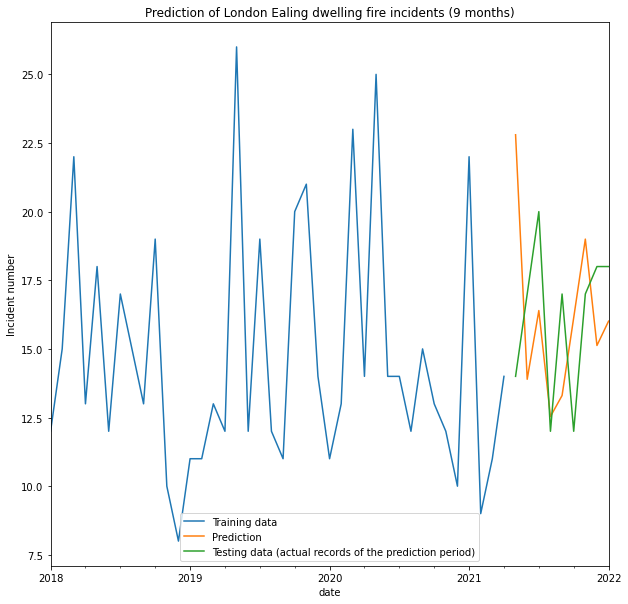

In [52]:
fig, ax = plt.subplots(figsize=(10, 10))
training.plot(ax=ax,legend='train')
prediction.plot(ax=ax)
testing.plot(ax=ax)
ax.set_ylabel('Incident number')
ax.set_title('Prediction of London Ealing dwelling fire incidents (9 months)')
ax.legend(['Training data', 'Prediction','Testing data (actual records of the prediction period)'])

In [53]:
mean_absolute_percentage_error(testing, prediction)

0.22069259645502243

In [54]:
mean_absolute_error(testing, prediction)

3.4159445132575197

In [55]:
mean_squared_error(testing, prediction, squared=False)

4.046442595836309

In [56]:
#https://stackoverflow.com/questions/40428931/package-for-listing-version-of-packages-used-in-a-jupyter-notebook
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

pandas==1.3.4
geopandas==0.6.1
pmdarima==1.8.5
libpysal==4.5.1
esda==2.4.1


In [59]:
data_spaceTime.head(1)

,IncidentNumber,PropertyCategory,DateOfCall,CalYear,TimeOfCall,Easting_rounded,Northing_rounded,IncGeo_BoroughName,GSS_CODE,latitude,longitude,Year_M,geometry
0,000177-01012018,Dwelling,2018-01-01,2018,3:30:35,535950,171750,LEWISHAM,E09000023,51.428455,-0.045823,2018-01,POINT (535950.000 171750.000)


In [63]:
data_spaceTime[['Easting_rounded']]

,Easting_rounded
0,535950
2,507150
4,529150
5,515050
7,528850
...,...
37617,512250
37618,551650
37623,535550
37624,530050


In [76]:
import numpy as np
import scipy.stats as st
#code adaption https://towardsdatascience.com/simple-example-of-2d-density-plots-in-python-83b83b934f67
# Extract x and y
x = data_spaceTime['Easting_rounded'].tolist()
y = data_spaceTime['Northing_rounded'].tolist()
# Define the borders
dX = (max(x) - min(x))/10000
dY = (max(y) - min(y))/10000
xmin = min(x) - dX
xmax = max(x) + dX
ymin = min(y) - dY
ymax = max(y) + dY
print(xmin, xmax, ymin, ymax)
# Create meshgrid
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

504144.49 559255.51 157145.72 199954.28


Text(0.5, 1.0, '2D Gaussian Kernel density estimation of London primary dwelling fire incidents')

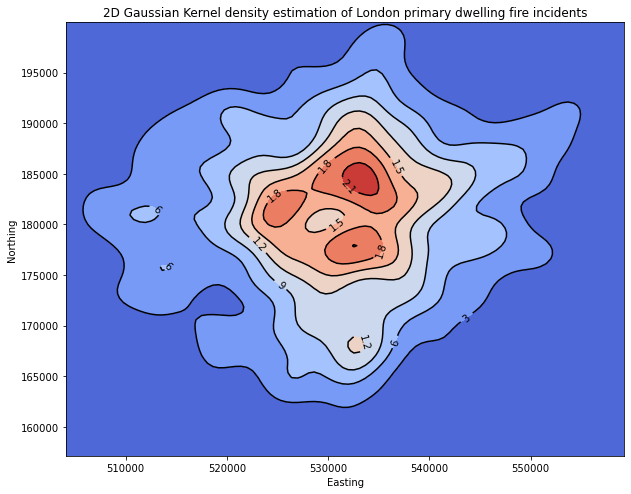

In [78]:
#code adaption https://towardsdatascience.com/simple-example-of-2d-density-plots-in-python-83b83b934f67
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
cfset = ax.contourf(xx, yy, f, cmap='coolwarm')
ax.imshow(np.rot90(f), cmap='coolwarm', extent=[xmin, xmax, ymin, ymax])
cset = ax.contour(xx, yy, f, colors='k')
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
plt.title('2D Gaussian Kernel density estimation of London primary dwelling fire incidents')